In [1]:
import geopandas as gpd
import plotly.express as px
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 

        ID    ID2  OBJECTID  GISJOIN DECADE        county NHGISST NHGISCTY  \
0    11643  59420         1  0900010   1790     Fairfield     090     0010   
1    11644  59421         2  0900030   1790      Hartford     090     0030   
2    11645  59422         3  0900050   1790    Litchfield     090     0050   
3    11646  59423       165  0900070   1790     Middlesex     090     0070   
4    11647  59424         4  0900090   1790     New Haven     090     0090   
..     ...    ...       ...      ...    ...           ...     ...      ...   
287  11930  59707       280  5101890   1790       Warwick     510     1890   
288  11931  59708       281  5101910   1790    Washington     510     1910   
289  11932  59709       282  5101930   1790  Westmoreland     510     1930   
290  11933  59710       283  5101955   1790      Woodford     510     1955   
291  11934  59711       284  5101990   1790          York     510     1990   

    ICPSRST ICPSRCTY      ICPSRNAM        state    SHAPE_AREA  

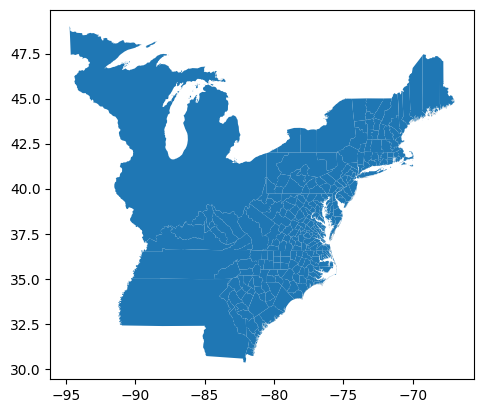

In [14]:
# import map shapefile
map_df = gpd.read_file("../data_raw/shapefiles/historicalcounties")

# rename columns and simplify map geometry (to make it run faster)
map_df.rename(columns = {'NHGISNAM':'county'}, inplace = True)
map_df.rename(columns = {'STATENAM':'state'}, inplace = True)
map_df["geometry"] = map_df["geometry"].simplify(0.01).buffer(0)

# limit to connecticut 
# map_df = map_df.loc[map_df['state'] == 'Connecticut']

print(map_df)

print(map_df.plot())

# save as a geojson
map_str = map_df.to_json()
map_gj = json.loads(map_str) # convert string json to dictionary json 

In [15]:
# get county populations 
county_pops = pd.read_csv("../data_raw/census_data/countyPopulation.csv", header=1)
county_pops = county_pops[county_pops["SE_T001_001"].notna()]
county_pops = county_pops.astype({"SE_T001_001":"int", "Geo_FIPS":"str"})
county_pops = county_pops[["Geo_FIPS", "SE_T001_001"]]
county_pops.rename(columns = {'SE_T001_001':'population'}, inplace = True)
county_pops

,Geo_FIPS,population
0,900010,36290
1,900030,38149
2,900050,38635
3,900070,18828
4,900090,30703
...,...,...
287,5101890,1690
288,5101910,5625
289,5101930,7722
290,5101955,9210


In [ ]:
# create choropleth map 
fig = px.choropleth_mapbox(county_pops, geojson=map_gj, locations='Geo_FIPS', color='population',
                           color_continuous_scale="Viridis",
                           range_color=(county_pops["population"].min(), county_pops["population"].max()),
                            featureidkey="properties.Geo_FIPS"
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

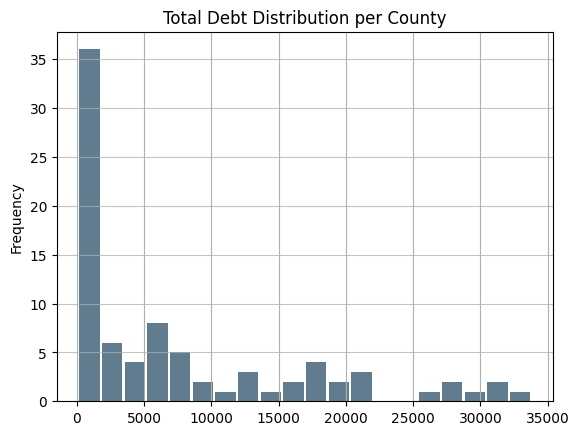

In [2]:
 # debt_by_county = pd.read_csv("../archive/S2022/debt_distribution_tables/CD_geographical_table_summary.csv")[["state", "county", "6p_total_sum"]]
debt_by_county = pd.read_csv("../data_clean/final_data_CD.csv")[["Group State", "Group County", "6p_total"]]
debt_by_county = debt_by_county.groupby(by="Group County")["6p_total"].sum()

debt_by_county = debt_by_county[debt_by_county.between(debt_by_county.quantile(.15), debt_by_county.quantile(.85))] # without outliers

 # Generate data on commute times.
size, scale = 500, 10
# commutes = pd.Series(np.random.gamma(scale, size=size) ** 1.5)

debt_by_county.plot.hist(grid=True, bins=20, rwidth=0.9,
                color='#607c8e')
plt.title('Total Debt Distribution per County')
plt.grid(axis='y', alpha=0.75)

## Displaying Outliers

In [2]:
# debt info per county 
debt_by_county = pd.read_csv("../data_clean/final_data_CD.csv")[["Group State", "Group County", '6p_total']]
debt_by_county = debt_by_county.groupby(by=["Group County", "Group State"]).agg(['size', 'sum'])
# debt_by_county = debt_by_county.to_frame()
# debt_by_county.rename(columns={'size':'count'}, inplace=True)
debt_by_county.reset_index(inplace=True)

debt_by_county.columns = debt_by_county.columns.droplevel(1)
debt_by_county.columns = ['county', 'state', 'count', '6p_total']

In [3]:
debt_by_county['6p_total']

0        190.025533
1         78.330000
2      49580.460000
3        755.550000
4      12204.070000
           ...     
144       44.060000
145     8412.157733
146     8468.770000
147     2161.090000
148    26412.540000
Name: 6p_total, Length: 149, dtype: float64

<Axes: >

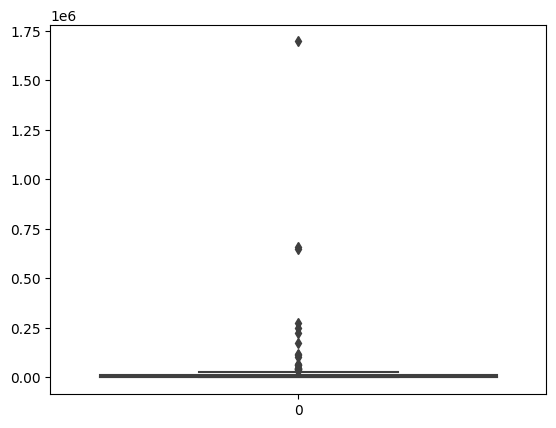

In [4]:
sns.boxplot(debt_by_county['6p_total'])

In [7]:
print(np.where(debt_by_county['6p_total']>(0.5 * 1000000)))

(array([  5,  92, 107]),)
